<a href="https://colab.research.google.com/github/andrew-veriga/MathForML/blob/master/ConvolutionalCoffieCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libs

In [1]:
import tensorflow as tf
import numpy as np

### Load picture

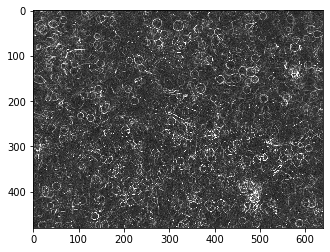

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path='https://github.com/andrew-veriga/MathForML/blob/master/CoffieCircles.png?raw=true'
Image = mpimg.imread(img_path)
plt.imshow(Image)

In [3]:
print(Image.shape)

(480, 640, 4)


###Prepare picture
Convert Image to 2D

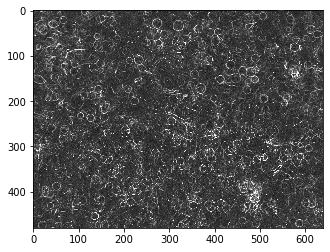

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Image = rgb2gray(Image)    
plt.imshow(Image, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

In [5]:
print (Image.shape)

(480, 640)


###Init variables

`MaxSize` - max size of square region

`MinSize` - min size of square region

`Contrast` - scalar set contrast of recognizing ring 
`Thick` - thickness of ring
`FoundCircles` - numpy array of centers and radiuces (3,None)

In [0]:
firstX=1
firstY=1
ImageSize = (48,90) #Image.shape
MaxSize = 40 
MinSize = 10
Contrast = 2.
Variance = 0.03
Thick = .8
FoundCircles = np.array([0,3])
_DEBUG_=False

In [0]:
# from scipy.spatial import distance
# for i in range(0,a.shape[0]):
#   d = [np.sum((a[i]-a[j])**2) for j in range(i+1,a.shape[0])] 
#   print(d) 

##Classic convolutions

### function FuzzyCircleConv

In [0]:
def FuzzyCircleConv(_box, _mask):
  # return sum(np.dot(_box,_mask))
  # mlt = np.multiply(_box,_mask)
  return np.sum(normto_0_1(_box)*_mask,axis=(-2,-1) )#/ np.var(ma.masked_values(mlt, 0.0 ))
  

###function getKernel

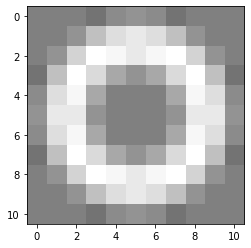

In [9]:
import itertools
import numpy as np
import random as rn
    # size=40 
    # thick = 1
MaxPix = np.max(Image)
MinPix = np.min(Image)

def getKernel( size, thick = 1. ):
    radius = (size-4) /2
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    #ring mask
    ring = np.ones((size,size), dtype=np.float32)/2 #np.random.rand(size,size)
    # print(selectedVecs.T[2])
    # print(np.max(selectedVecs.T[2]))
    maxMask= np.max(selectedVecs.T[2])
    # ring = -(ring - MinPix)/(MaxPix-MinPix)
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]+=k-np.mean(Image) 

    return ring
plt.imshow(getKernel(11,2),cmap=plt.get_cmap('gray'), vmin=-1, vmax=2)

In [0]:
import itertools
import numpy as np

    # size=40 
    # thick = 1


def get2Kernel( size, thick = 1. ):
    radius = (size-2) /2
    center = np.array([size/2-.5,size/2-.5])
    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    #ring mask
    ring = np.zeros((size,size), dtype=np.float) #np.random.rand(size,size)
    
    vectors = [[(i,j, thick*3 - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=-1

    vectors = [[(i,j, thick - np.abs(np.linalg.norm((i,j) - center) - radius)) for j in range(size)] for i in range(size)]
    l = itertools.chain.from_iterable(zip(*vectors))
    
    selectedVecs = np.array(list(filter(lambda v: v[2] > 0. ,l)))
    for (i,j,k) in (selectedVecs):
      ring[np.int(i),np.int(j)]=1+k#-np.mean(Image)

    return ring

# for size, x,y, isRing in data:
#   kernel = get2Kernel( size, 1 )
#   square = np.copy(Image[y:y+size, x:x+size])
#   square2 = square + rotate_image(square,30)
#   print('is ring:', isRing,'Conv value:',FuzzyCircleConv(square,kernel)/size, 'rotation Conv value:', FuzzyCircleConv(square2,kernel)/size )      
#   fig, ax = plt.subplots(figsize=(10,5))
#   ax = fig.add_subplot(1,2,1)
#   ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

#   ax1=fig.add_subplot(1,2,2)

#   ax1.imshow(np.multiply(square,kernel), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
# fig.show()


In [11]:
print(get2Kernel(10,2).min())

-1.0


###some normalizations
$$ range [-1,1]: x'' = 2\frac{x - \min{x}}{\max{x} - \min{x}} - 1$$

$$range [0,1]: x' = \frac{x - \min{x}}{\max{x} - \min{x}}$$
$$range [a;b]: x''' = (b-a)\frac{x - \min{x}}{\max{x} - \min{x}} + a$$

In [0]:
def nrm(_b,_mask):
  _box = np.copy(_b)
  _box-= np.min(_box)
  _box /=np.max(_box)
  _box= _box - np.mean(_box[_mask])-.01 #[:,:,:,np.newaxis] -.01 #np.percentile(box,90)-1
  return _box

def normto_avgOne(ar,_mask):
  ar_min = ar - ar.min(axis=(-2,-1), keepdims=True)
  ar_max = ar_min / ar_min.max(axis=(-2, -1), keepdims=True)
  ar_mean = ar_max - ar_max[:,:,_mask].mean(axis=(-1), keepdims=True)[:,:,:,np.newaxis] -.01
  return ar_mean

def normto_0_2(ar):
  ar_min = ar.min(axis=(-2,-1), keepdims=True)
  ar_max = ar.max(axis=(-2, -1), keepdims=True)
  add = np.full((ar.shape[-2],ar.shape[-1]),0.5)
  return (((ar - ar_min)/(ar_max-ar_min))+add)

def normto_0_1(ar):
  ar_min = ar.min(axis=(-2,-1), keepdims=True)
  ar_max = ar.max(axis=(-2, -1), keepdims=True)
  return (((ar - ar_min)/(ar_max-ar_min)))

###One example of arbitrary ring

Conv value: -0.0003674284299807884


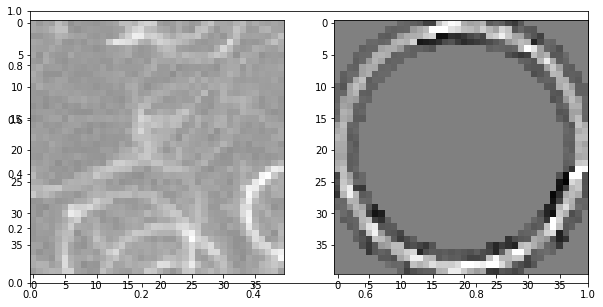

In [13]:
kernel = get2Kernel( MaxSize, 1 )
square = Image[firstY:firstY+MaxSize, firstX:firstX+MaxSize]
    
#ring visualisation
#ring visualisation
fig, ax = plt.subplots(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)

ax1=fig.add_subplot(1,2,2)

ax1.imshow(np.multiply(square,kernel), cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
fig.show()
print('Conv value:',FuzzyCircleConv(square,kernel)/MaxSize**2)


###Try classic convolutions

conv value 0.007121847987433266
0.012660947118135384


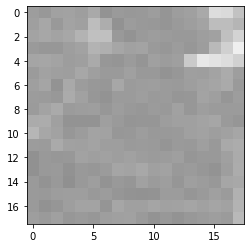

In [14]:
  
  SquareSize=18
  Thick=1
  kernel=get2Kernel( SquareSize, Thick )
  kernel_size =kernel.shape[0]
  pad_size = kernel_size // 2
  rest = kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.zeros((pad_size, ImageSize[1]+pad_size*2), dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = kernel.shape
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)
  #arbirtary region
  square = sub_matrices[pad_size,pad_size,:,:]
  plt.imshow(square,plt.get_cmap('gray'), vmin=-1, vmax=1)
  print('conv value', FuzzyCircleConv(square,kernel)/kernel_size**2)
  m=np.sum(np.multiply(sub_matrices,kernel), axis=(2,3))/(kernel_size**2)
  # m = np.sum(np.multiply(square))/(kernel_size**2)
  print(m[pad_size,pad_size])  

In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
def conv(_kernel):
  # _kernel = getKernel( size, Thick )
  kernel_size = _kernel.shape[0]
  pad_size = kernel_size // 2
  rest = 0#kernel_size % 2
  horisontal_pad = np.random.rand(ImageSize[0], pad_size)#, dtype=np.float64)
  vertical_pad = np.random.rand(pad_size, ImageSize[1]+pad_size*2)#, dtype=np.float64)
  a = np.hstack((horisontal_pad, Image[:ImageSize[0],:ImageSize[1]], horisontal_pad))
  a = np.vstack((vertical_pad, a, vertical_pad))

  sub_shape = (_kernel.shape)
  view_shape = (ImageSize[0]+ rest,ImageSize[1]+ rest, sub_shape[0] , sub_shape[1] )
  strides = a.strides + a.strides
  sub_matrices = np.lib.stride_tricks.as_strided(a,view_shape,strides)


  # m=np.sum(np.multiply(sub_matrices,_kernel), axis=(2,3))/(kernel_size**2)
  m = np.einsum('ij,klij->kl',_kernel,sub_matrices)/kernel_size**2
  return m
  

##Rotate convolutions

###function isCircleFound
calculate average brightness over all pixels of current square;
If pixels of SelectedRing have avg brightness more then avg brightness over all square - circle is found 


In [0]:
#from scipy.special import softmax

def isCircleFound(_box, _mask, _backmask):
  background = np.logical_xor(_backmask, _mask)  
  bias = np.min(_box)
  brightness = (lambda arr: np.percentile(arr-bias,90))#/(np.max(arr)-np.min(box))))
  if _DEBUG_:

    print ('ring brightness', brightness(_box[_mask]))
    print ('back brightness', brightness(_box[background]))
    print('ring.var', np.var(_box[_mask]-bias))
    print('full.var', np.var(_box-bias))
    print('back.var', np.var(_box[background]-bias))
  return ((brightness(_box[_mask]) / brightness(_box[background])) /np.var(_box[_mask]))#/np.var(_box[~_mask]) < 1)
  

###function getMask
create square matrix of boolean as a ring of Trues inscribed in a square of Falses

ring brightness 0.48191261165991417
back brightness 0.45368014275446544
ring.var 0.03142975629028775
full.var 0.01948763594052808
back.var 0.028536471715980227
33.79694987013569


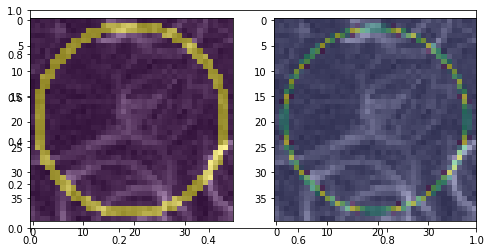

In [17]:
import itertools

def getMask( size, thick = 1 ):
    radius = (size-3)/2 
    center = np.array([(size-1)/2,(size-1)/2])
    vectors = np.array([[(i,j) for j in range(size)] for i in range(size)], dtype=np.int)
    l = itertools.chain.from_iterable(zip(*vectors))
    
    # list of pairs (x,y) belong of ring
    selectedVecs = np.array(list(filter(lambda v: np.abs(np.linalg.norm(v - center) - radius) < thick,l)))
    # print(selectedVecs)
    #ring mask
    ring = np.array(np.zeros((size,size),dtype=np.bool))
    
    for (i,j) in (selectedVecs):
      ring[i,j]=True
    
    return ring, center

square = Image[:MaxSize,:MaxSize]
Mask, _ = getMask(MaxSize,1) 
backMask, _ =getMask(MaxSize,2) 
#ring visualisation
fig, _ = plt.subplots(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(Mask,alpha=.5)
ax = fig.add_subplot(1,2,2)
ax.imshow(square, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax.imshow(getKernel(MaxSize,1),alpha=.5)
fig.show()
_DEBUG_=True
print (isCircleFound(square, Mask, backMask))
_DEBUG_=False

###function rotate_image

In [0]:
import cv2
# https://issue.life/questions/43892506/
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape # image shape has 2 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    # rotation_mat[0, 2] += bound_w/2 - image_center[0]
    # rotation_mat[1, 2] += bound_h/2 - image_center[1]
    # rotation_mat[0, 2] += bound_w/2 - image_center[0]
    # rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (width, height))
    return rotated_mat
  

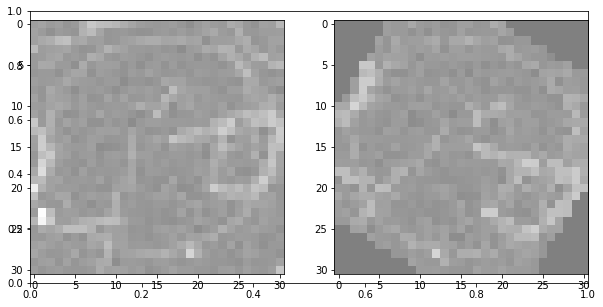

In [19]:
  import math
  _angle = np.pi / 6
  (size, x,y) = (31,151,67)
  _box = Image[y:y+size, x:x+size]
# def RotateConv(_box,_angle):
  size = _box.shape[0]
  center = np.array([size//2,size//2],dtype=np.int)
  coords = np.indices((size, size)).reshape(2, -1)
  coords=np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int)
  
  R_mat = np.array([
    [np.cos(_angle), np.sin(_angle), 0],
    [-np.sin(_angle), np.cos(_angle), 0],
    [0, 0, 1]
  ])
  T = np.array([
    [1, 0, center[1]],
    [0, 1, center[0]],
    [0, 0, 1]
  ])
  A = T @ R_mat @ np.linalg.inv(T)
  
  warp_coords = np.round(A @ coords).astype(np.int)

  newbox = np.zeros_like(_box)
  xcoord, ycoord = warp_coords[0, :], warp_coords[1, :]
  # Get pixels within image boundary
  indices = np.where((xcoord >= 0) & (xcoord < size) &
                    (ycoord >= 0) & (ycoord < size))
  
  x2, y2 = xcoord[indices], ycoord[indices]
  xpix, ypix = coords[0][indices], coords[1][indices]


  newbox[ypix,xpix] = _box[y2,x2]
  
  fig, ax = plt.subplots(figsize=(10,5))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(_box, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
  ax1=fig.add_subplot(1,2,2)
  ax1.imshow(newbox, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)
  fig.show()

###Some examples of founded ring

In [0]:
data=np.array([
      [17,348,21,0],
      [21,1,1,0],
      [18,168,45,0],
      [29,152,68,1],
      [21,147, 226,1],
      [21,157, 236,1],
      [18, 58, 13,1],
      [16, 133, 50,1],
      [16, 138, 76,1]
      ])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


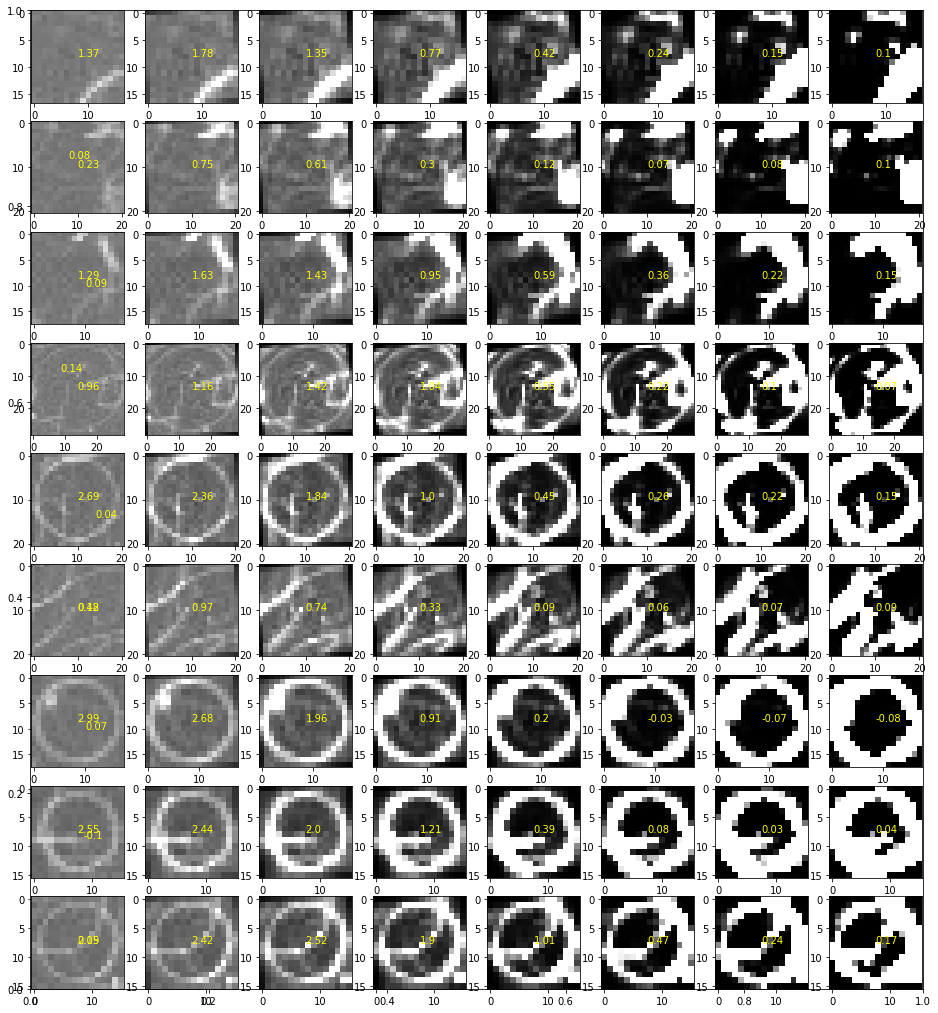

In [21]:
Contrast = 1.8
Variance = 0.03
# data array of some square [size, x, y]
# the first of data is nothing but all other are founded rings
len = data.shape[0]
cnt =8
fig, ax = plt.subplots(figsize=(2*cnt,2*len))
i=1
Thick = 0.8
_angle = 4

for size,x,y,isRing in data:
  Mask, center = getMask( size, Thick )
  backMask,_ = getMask(size,3*Thick)
  
  #ring visualisation
  box = np.array(Image[y:y+size,x:x+size])
  box = box - np.mean(box) + 1. # normalization to mean = 1
  ax = fig.add_subplot(len,cnt,i)
  ax.imshow(box, cmap=plt.get_cmap('gray'), vmin=0, vmax=2)
  ax.text(center[0],center[1],str(round(FuzzyCircleConv(normto_0_1(box),get2Kernel(size,1.2))/size,2)),color='yellow')
  newbox = np.multiply(box, rotate_image(box,_angle))
  for j in range(1,cnt+1):
    ax=fig.add_subplot(len,cnt,i+1)
    ax.imshow(newbox, cmap=plt.get_cmap('gray'), vmin=0, vmax=2)
    ax.text(center[0],center[1],str(round(FuzzyCircleConv(normto_0_1(newbox),get2Kernel(size,1.2))/size,2)),color='yellow')
    newbox = np.multiply(newbox, rotate_image(newbox,_angle))
    i+=1
    if (i==cnt*len):
      break;

 
fig.show()

_DEBUG_=False


### try masqueraded convolutions

In [0]:
def getRotateCoords(_R, _size, _center=[0,0]):
  if (  _center[0] == 0 and _center[1]==0):
    _center = np.array([_size//2,_size//2],dtype=np.int)

  coords = np.indices((_size, _size)).reshape(2, -1)
  coords=np.vstack((coords, np.ones(coords.shape[1],dtype=np.int)))
  T = np.array([
    [1., 0., _center[1]],
    [0., 1., _center[0]],
    [0., 0., 1.]
  ])
  Rotate_matrix = T @ _R @ np.linalg.inv(T)
  warp_coords = np.round(Rotate_matrix @ coords,0).astype(np.int)
  newbox = np.zeros((_size,_size))
  xcoord, ycoord = warp_coords[0, :], warp_coords[1, :]
  # Get pixels within image boundary
  indices = np.where((xcoord >= 0) & (xcoord < _size) &
                    (ycoord >= 0) & (ycoord < _size))
  
  x_new, y_new = xcoord[indices], ycoord[indices]
  x_old, y_old = coords[0][indices], coords[1][indices]
  return x_old, y_old, x_new,y_new
  


In [0]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy

def strides(_image, _gridshape):
  padded_im = np.random.random(size=(np.add(_image.shape, _gridshape) - 1))
  padded_im[_gridshape[0]//2:_gridshape[0]//2+_image.shape[0],_gridshape[1]//2:_gridshape[1]//2 +_image.shape[1]] = _image
  # view_shape = tuple(np.subtract(_image.shape, _gridshape) + 1) + _gridshape
  view_shape = _image.shape + _gridshape
  strides = padded_im.strides + padded_im.strides
  # print(view_shape)
  return np.lib.stride_tricks.as_strided(padded_im,view_shape,strides,writeable=False)
  

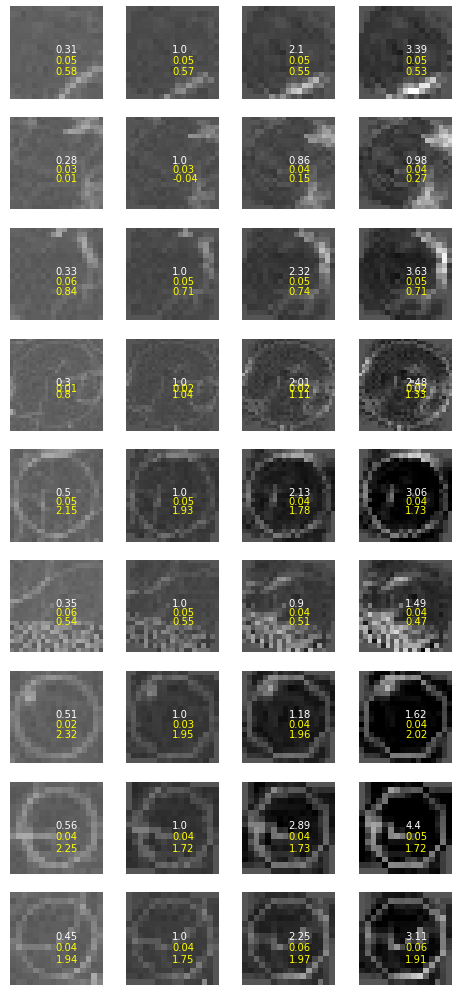

In [24]:
#https://stackoverflow.com/questions/43086557/convolve2d-just-by-using-numpy
# df = pd.DataFrame(
#     columns=['ID','size','x','y','ring brightness', 'back brightness', 'ring var','full var','back var'],
#     dtype=np.float32
#     )
# trial variables fro debugging

ImageSize=[250,365]
angle = 12
# area for search
image_area=np.copy(Image[:ImageSize[0],:ImageSize[1]])

len = data.shape[0]
# matrix for rotate
r_angle = np.radians(angle)
R = np.array([
  [np.cos(r_angle), np.sin(r_angle), 0],
  [-np.sin(r_angle), np.cos(r_angle), 0],
  [0, 0, 1]
])
    

cnt=2 #number of rotates
fig, ax = plt.subplots(figsize=(2*(cnt+2),2*len))
ax.axis('off')
im_index = 0
for row in range(len):
  size,X,Y,isRing = data[row]
  X +=(size//2)
  Y +=(size//2)
  # ring boolean masks
  mask, center = getMask(size,0.8)
  x_old, y_old,x_new, y_new = getRotateCoords(R,size,center)
  
  kernel = get2Kernel(size,1.)
    
  #normalise their to average = 1
  # box-= np.min(box)
  # box /=np.max(box)
  # box-= np.mean(box)-1
  sub_matrices = strides(image_area,mask.shape)
  
  new_matrices = np.zeros_like(sub_matrices)
  
  brightness = (lambda arr, msk: np.mean((arr)[:,:,msk],axis=-1))
  
  #multiply all matrices by their rotated copies elementwise
  
  im_index+=1
  v = brightness(sub_matrices,mask)[Y, X]#/ brightness(sub_matrices,~mask) )
  v1 = normto_avgOne(sub_matrices,mask)[Y,X][mask].var()
  v2 = FuzzyCircleConv(sub_matrices,kernel)[Y,X] / size
  ax = fig.add_subplot(len,cnt+2,im_index)
  ax.axis('off')
  ax.imshow(normto_0_1(sub_matrices[Y, X]), cmap=plt.get_cmap('gray'),vmin=-1,vmax=2)
  ax.text(center[0],center[1],str(round(v,2)),color='white')
  ax.text(center[0],center[1]+2,str(round(v1,2)),color='yellow')
  ax.text(center[0],center[1]+4,str(round(v2,2)),color='yellow')
  
  new_matrices[:,:,y_old,x_old] = normto_avgOne(sub_matrices,mask)[:,:,y_new,x_new]
  first_brightness = brightness(new_matrices,mask)
  v = (brightness(new_matrices,mask) / first_brightness)[Y, X]
  v1 = normto_avgOne(new_matrices,mask)[Y,X][mask].var()
  v2 = FuzzyCircleConv(new_matrices,kernel)[Y,X] / size

  #v2 = np.sum(normto_0_1(new_matrices) * kernel,axis=(-2,-1))[Y,X]/ size
  
  im_index+=1
  ax = fig.add_subplot(len,cnt+2,im_index)
  ax.axis('off')

  ax.imshow(new_matrices[Y, X], cmap=plt.get_cmap('gray'),vmin=-1,vmax=2)
  ax.text(center[0],center[1],str(round(v,2)),color='white')
  ax.text(center[0],center[1]+2,str(round(v1,2)),color='yellow')
  ax.text(center[0],center[1]+4,str(round(v2,2)),color='yellow')
 
  for col in range(cnt):
    new_matrices[:,:,y_old,x_old] += normto_avgOne(new_matrices,mask)[:,:,y_new,x_new]
    # new_matrices = normToOne(new_matrices)
    im_index+=1
    v = (brightness(new_matrices,mask) / first_brightness)[Y, X]
    v1 = normto_avgOne(new_matrices,mask)[Y,X][mask].var()
    v2 = FuzzyCircleConv(new_matrices,kernel)[Y,X] / size

    ax = fig.add_subplot(len,cnt+2,im_index)
    ax.axis('off')
    ax.imshow(new_matrices[Y, X], cmap=plt.get_cmap('gray'),vmin=-1,vmax=2)
    # ax.imshow(mask,alpha=.5)
    ax.text(center[0],center[1],str(round(v,2)),color='white')
    ax.text(center[0],center[1]+2,str(round(v1,2)),color='yellow')
    ax.text(center[0],center[1]+4,str(round(v2,2)),color='yellow')
  #   # return m

###Summation conv try out

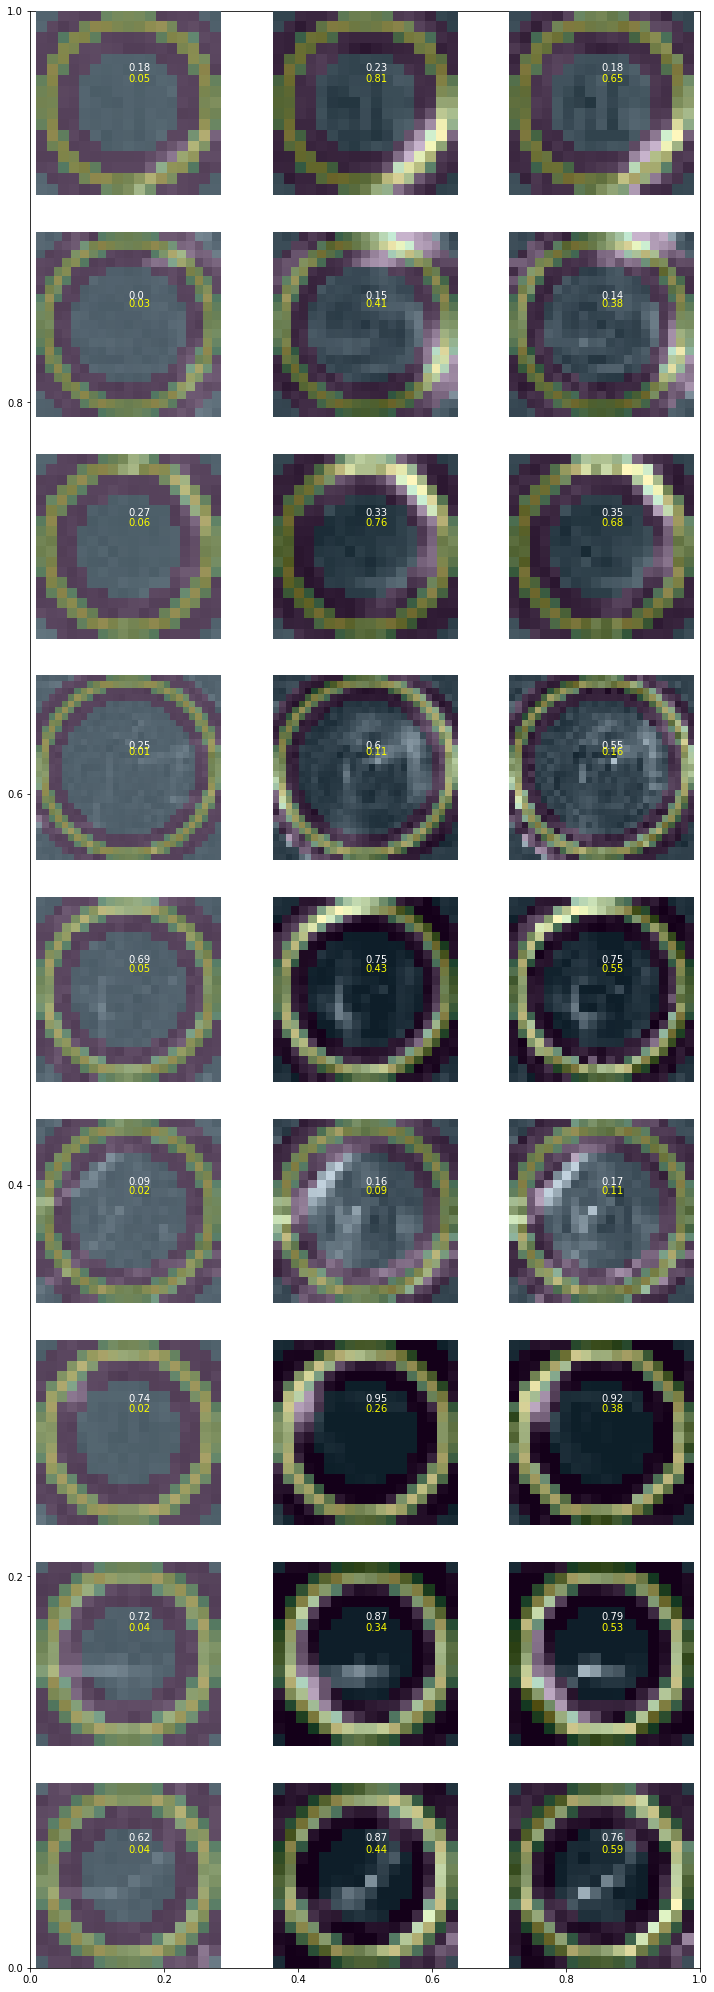

In [25]:

len = data.shape[0]
fig, ax = plt.subplots(figsize=(4*3,4*len))
row = 0
angle =12
# matrix for rotate
r_angle = np.radians(angle)
R = np.array([
  [np.cos(r_angle), -np.sin(r_angle), 0],
  [np.sin(r_angle), np.cos(r_angle), 0],
  [0, 0, 1]
])
for size,x,y, isRing in data:
  mask, center=getMask(size,.8)
  box = normto_0_1(Image[y:y+size,x:x+size])
  rotated_box = box + nrm(rotate_image(box,angle),mask)

  t_box = np.zeros_like(box)
  x_old,y_old,x_new, y_new = getRotateCoords(R, size, center)
  t_box[y_old,x_old] = box[y_new,x_new]
  transformed_box = box+nrm(t_box,mask)#(box-np.mean(box / np.max(box-np.min(box)))+1.)*t_box
  
  for i in range(2):
    rotated_box += nrm(rotate_image(rotated_box,angle),mask)
    t_box[y_old,x_old] = transformed_box[y_new,x_new]
    transformed_box += nrm(t_box,mask)
    
  kernel = get2Kernel(size,1.)
  
  # ax.axis('off')
  col=1
  for arr in (box, rotated_box, transformed_box):
    ax = fig.add_subplot(len,3,col+row)
    ax.axis('off')
    ax.imshow(arr, cmap=plt.get_cmap('gray'),vmin=-1, vmax=2)
    ax.imshow(kernel,alpha=.3 )
    txtpos = center[0]-3
    ax.text(center[1],txtpos,str(round(FuzzyCircleConv(arr,kernel)/(size*np.pi),2)),color='white')
    ax.text(center[1],txtpos+1,str(round(arr[mask].var(),2)),color='yellow')
    col+=1
  row+=3

In [28]:
def nrm(_b,_mask):
  _box = np.copy(_b)
  _box-= np.min(_box)
  _box /=np.max(_box)
  _box= _box - np.mean(_box[_mask])-.01 #[:,:,:,np.newaxis] -.01 #np.percentile(box,90)-1
  return _box

def normto_avgOne(ar,_mask):
  ar_min = ar - ar.min(axis=(-2,-1), keepdims=True)
  ar_max = ar_min / ar_min.max(axis=(-2, -1), keepdims=True)
  ar_mean = ar_max - ar_max[:,:,_mask].mean(axis=(-1), keepdims=True)[:,:,:,np.newaxis] -.01
  return ar_mean
# fig, ax = plt.subplots(figsize=(2*(cnt+2),2*len))
# ax.axis('off')

#for 
image_area = Image[:ImageSize[0],:ImageSize[1]]
size,x,y, isRing = data[3]
mask, center=getMask(size,.8)
kernel = get2Kernel(size,1.)
x_old,y_old,x_new, y_new = getRotateCoords(R, size, center)

sub_matrices = normto_0_1(strides(image_area,mask.shape))
box = normto_0_1(image_area[y:y+size,x:x+size])

# ax = fig.add_subplot(1,2,1)
# ax.imshow(sub_matrices[y+size//2,x+size//2], cmap=plt.get_cmap('gray'),vmin=-1, vmax=2)
# ax = fig.add_subplot(1,2,2)
# ax.imshow(box, cmap=plt.get_cmap('gray'),vmin=-1, vmax=2)

t_box = np.zeros_like(box)
t_box[y_old,x_old] = box[y_new,x_new]
transformed_box = box+nrm(t_box,mask)#(box-np.mean(box / np.max(box-np.min(box)))+1.)*t_box

t_matrices = np.zeros_like(sub_matrices)
t_matrices[:,:, y_old,x_old] = sub_matrices[:,:, y_new,x_new]
new_matrices = sub_matrices + normto_avgOne(t_matrices,mask)

print (new_matrices[y+size//2,x+size//2].mean(),transformed_box.mean())
for i in range(2):
  t_box[y_old,x_old] = transformed_box[y_new,x_new]
  transformed_box += nrm(t_box,mask)
  t_matrices[:,:, y_old,x_old] = new_matrices[:,:, y_new,x_new]
  new_matrices += normto_avgOne(t_matrices,mask)

print ((FuzzyCircleConv(new_matrices,kernel)/(size*np.pi))[y+size//2,x+size//2], FuzzyCircleConv(transformed_box,kernel)/(size*np.pi))





0.10619678104297954 0.10619678104297953
0.5534304294397285 0.5534304294397285


## Main loops


In [41]:
def rotate_conv_by_strides(_img, size):
  print('size:',size)
  mask, center=getMask(size,.8)
  kernel = get2Kernel(size,1.)
  x_old,y_old,x_new, y_new = getRotateCoords(R, size, center)

  sub_matrices = normto_0_1(strides(image_area,mask.shape))
  
  # ax = fig.add_subplot(1,2,1)
  # ax.imshow(sub_matrices[y+size//2,x+size//2], cmap=plt.get_cmap('gray'),vmin=-1, vmax=2)
  # ax = fig.add_subplot(1,2,2)
  # ax.imshow(box, cmap=plt.get_cmap('gray'),vmin=-1, vmax=2)

  t_matrices = np.zeros_like(sub_matrices)
  t_matrices[:,:, y_old,x_old] = sub_matrices[:,:, y_new,x_new]
  new_matrices = sub_matrices + normto_avgOne(t_matrices,mask)

  for i in range(2):
    t_matrices[:,:, y_old,x_old] = new_matrices[:,:, y_new,x_new]
    new_matrices += normto_avgOne(t_matrices,mask)
    
  return FuzzyCircleConv(new_matrices,kernel)/(size*np.pi)

ImageSize=[240,320]
# area for search
image_area=np.copy(Image[:ImageSize[0],:ImageSize[1]])
MinSize,MaxSize = (10,20)
angle =4
# matrix for rotate
r_angle = np.radians(angle)
R = np.array([
  [np.cos(r_angle), -np.sin(r_angle), 0],
  [np.sin(r_angle), np.cos(r_angle), 0],
  [0, 0, 1]
])

res = [rotate_conv_by_strides(image_area, _s ) for _s in range(MinSize,MaxSize+1)]
FoundCircles = np.dstack(res)


size: 10
size: 11
size: 12
size: 13
size: 14
size: 15
size: 16
size: 17
size: 18
size: 19
size: 20


In [35]:
size,x,y, isRing = data[3]
size, x,y
#res = rotate_conv_by_strides(image_area, size )
print (FoundCircles[y+size//2,x+size//2,size-MinSize])


0.5534304294397285


In [30]:
res[13,58]

0.12612081304225622

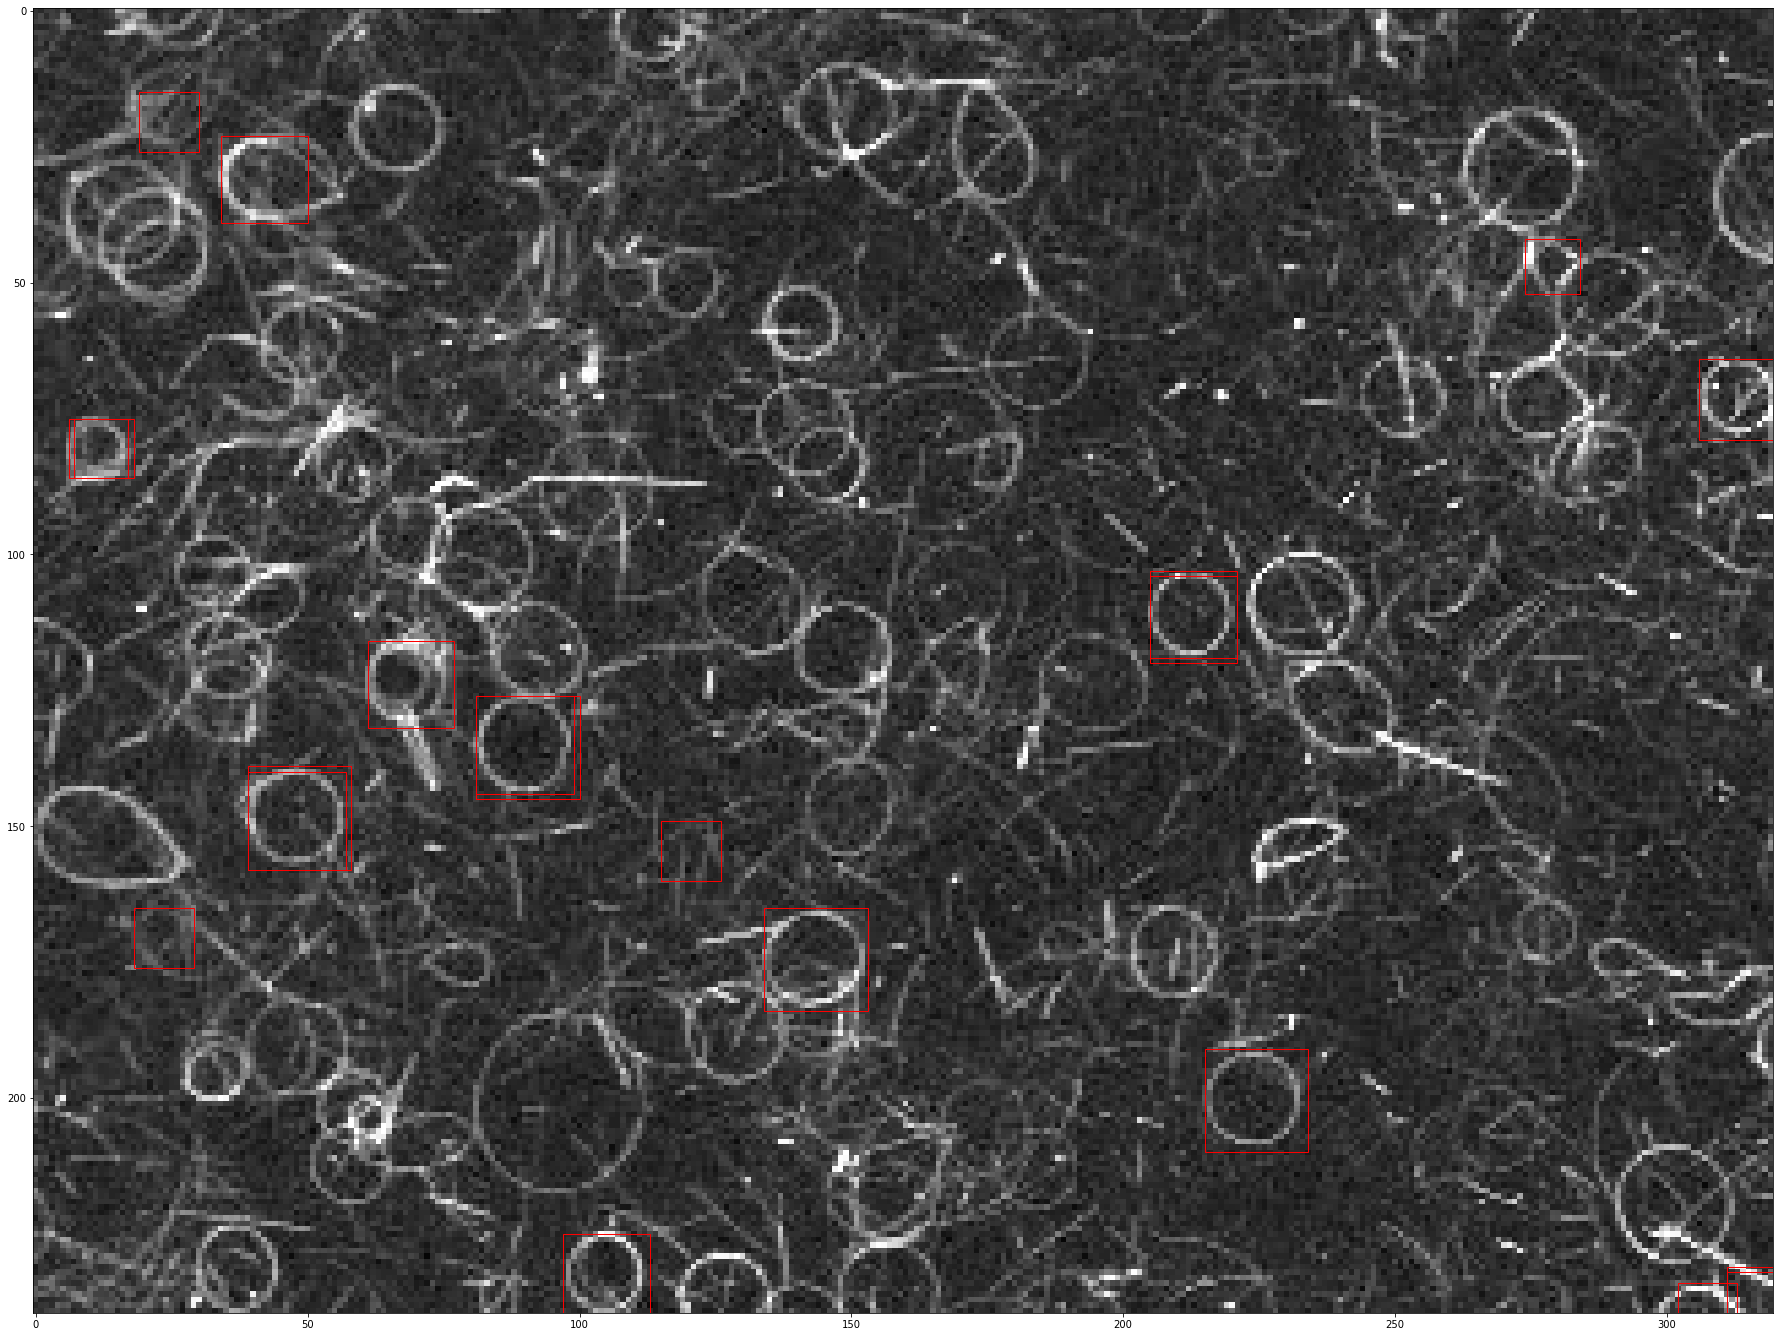

In [46]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(image_area,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

for y in range(FoundCircles.shape[0]):
  for x in range(FoundCircles.shape[1]):
    for s in range(MinSize,MaxSize+1):
      if (FoundCircles[y,x, s-MinSize]>.85):
        rect = patches.Rectangle((x-s//2,y-s//2),s,s,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
plt.show(fig)

In [0]:
FoundCircles.shape

(480, 640, 6)

In [0]:
import pandas as pd

MinSize=20
MaxSize=40

df = pd.DataFrame(
      columns=['y','x','size','ring brightness', 'back brightness', 'ring var','full var','back var'],
      dtype=np.float32
      )

# ConvMatrices = np.empty((0,ImageSize[0],ImageSize[1]))
for size in range(MinSize,MaxSize):
  #print('size '+str(size))
  new_rows = mask_conv(getMask( size, .8 ),getMask( size, 2 ))

  df = df.append(pd.DataFrame(new_rows))
  # ConvMatrices= np.concatenate((ConvMatrices, np.reshape(res,(1,ImageSize[0],ImageSize[1]))),axis=0)

In [0]:
df.to_csv('df_coffieCircles.csv')

In [0]:

for size,x,y,_ in data:
  res= df.loc[(df.size==size) & (df.x==x) & df.y==y]
  print (res)
  #print(ConvMatrices[size-MinSize,y+size//2,x+size//2])    


In [0]:
print(ConvMatrices.shape)

In [0]:
# outfile = TemporaryFile()
np.save('ConvMatrices', ConvMatrices)

###Loop of masqueraded convolutions


In [0]:


Contrast=0.17
import matplotlib.patches as patches
# plt.ioff()
fig, ax = plt.subplots(figsize=(32, 24))
ax.imshow(Image,cmap=plt.get_cmap('gray') )
# Create a Rectangle patch

cnt=0
for size in range(MinSize,MaxSize):
  print('size: ',size)
  convs = ConvMatrices[size-MinSize,size//2:-size//2,size//2:-size//2]
  for i in range(size//2,convs.shape[0]-size//2):
    y= i 
    for j in range(size//2, convs.shape[1]-size//2):
      x = j 
      if (convs[i,j]>170):
        rect = patches.Rectangle((x,y),size,size,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        lbl = str(size)+':'+str(x)+':'+str(y)
        ax.text(x,y, lbl,
          color='red')
        # plt.text(x,y,lbl,facecolor='r')
        #print(x, y, convs[i,j])
        cnt+=1
      if (cnt>60):
        break
    else:
      continue
    break
  else:
    continue
  break

plt.show()